In [1]:
from datautils import get_dls
from src.models.resnet import ResNet
from src.models.patchTST import PatchTST
from src.learner import  transfer_weights
from torchinfo import summary
import torch.nn as nn
from src.basics import set_device
import torch

from src.callback.patch_mask import Patch
set_device()

class params:
    def __init__(self, **kwargs):
        for key in kwargs:
            setattr(self, key, kwargs[key])

In [2]:
dls = get_dls(params(batch_size=1, dset='gunpoint', num_workers=1)) 

In [81]:
model_rsnt = ResNet(1, 'classification', 2, .2)
model_ptst = PatchTST(c_in=1,
                target_dim=2,
                patch_len=16,
                stride=8,
                num_patch=17,                
                n_layers=3,
                n_heads=16,
                d_model=128,
                shared_embedding=True,
                d_ff=256,                        
                dropout=.2,
                head_dropout=0,
                act='relu',
                head_type='classification',
                res_attention=False
                )    

In [82]:
w_path_rsnt = 'saved_models/gunpoint/resnet/based_model/resnet_cw150_epochs-pretrain20_model1.pth'
w_path_ptst = 'saved_models/gunpoint/patchtst_supervised/based_model/patchtst_supervised_cw150_tw2_patch16_stride8_epochs30_model1.pth'
model_ptst = transfer_weights(weights_path=w_path_ptst, model=model_ptst, exclude_head=False, device='cuda')
model_rsnt = transfer_weights(weights_path=w_path_rsnt, model=model_rsnt, exclude_head=False, device='cuda')



weights from saved_models/gunpoint/patchtst_supervised/based_model/patchtst_supervised_cw150_tw2_patch16_stride8_epochs30_model1.pth successfully transferred!

weights from saved_models/gunpoint/resnet/based_model/resnet_cw150_epochs-pretrain20_model1.pth successfully transferred!



In [83]:
model_ptst.eval()
model_rsnt.eval()

ResNet(
  (block1): ResNetBlock(
    (conv1): Conv1d(1, 64, kernel_size=(8,), stride=(1,), padding=same, bias=False)
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=same, bias=False)
    (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=same, bias=False)
    (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Sequential(
      (0): Conv1d(1, 64, kernel_size=(1,), stride=(1,), padding=same, bias=False)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (block2): ResNetBlock(
    (conv1): Conv1d(64, 128, kernel_size=(8,), stride=(1,), padding=same, bias=False)
    (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(128, 1

In [84]:
from scipy.spatial.distance import pdist, cdist, squareform

In [85]:
class GAP_Resnet(nn.Module):

    def __init__(self, model):
        super(GAP_Resnet, self).__init__()

        self.model = nn.Sequential(model.block1, model.block2, model.block3, model.gap)
        

    def forward(self, x):
        x = x.permute(0,2,1)
        out = self.model(x)
        return out

In [86]:
class GAP_PatchTST(nn.Module):

    def __init__(self, model):
        super(GAP_PatchTST, self).__init__()

        self.model = model.backbone
        self.patch = Patch(seq_len = 150, patch_len = 16, stride = 8)
        self.flatten = nn.Flatten(start_dim=1)

    def forward(self, x):
        x = self.patch(x)
        out = self.model(x)
        out = out[:,:,:,-1]            
        out = self.flatten(out)  
        return out

In [87]:
gap_m = GAP_Resnet(model_rsnt)

In [88]:
gap_p = GAP_PatchTST(model_ptst)

In [111]:
dl = iter(dls.test)


In [112]:
N = 30
X = []
X_GAP_ptst = []
X_GAP_rsnt = []
Y = []
for _ in range(N):
    x, y = next(dl)
    x = x.unsqueeze(-1)
    X.append(x)
    Y.append(y)
    X_GAP_ptst.append(gap_p(x.cuda()))
    X_GAP_rsnt.append(gap_m(x.cuda()))

In [113]:
def to_numpy(l):
    return [el.detach().cpu().numpy( ) for el in l ]

In [114]:
X_GAP_ptst = to_numpy(X_GAP_ptst)
X_GAP_rsnt = to_numpy(X_GAP_rsnt)

In [115]:
Y = to_numpy(Y)
X = to_numpy(X)

In [116]:
import numpy as np

In [117]:
X = np.array(X)
X_GAP_ptst = np.array(X_GAP_ptst)
X_GAP_rsnt = np.array(X_GAP_rsnt)

In [118]:
X = X.reshape(N,150)
X_GAP_rsnt = X_GAP_rsnt.reshape(N,128)
X_GAP_ptst = X_GAP_ptst.reshape(N,128)

In [119]:
Xdist = squareform(pdist(X))

In [120]:
X_GAP_rsnt_dist = squareform(pdist(X_GAP_rsnt))
X_GAP_ptst_dist = squareform(pdist(X_GAP_ptst))

In [121]:
def stress(Xdist, X_GAP_dist):
    d_norm = np.sum(X_GAP_dist**2)
    up = np.sum((X_GAP_dist-Xdist)**2)
    return np.sqrt(up/d_norm)

In [122]:
stress(Xdist, X_GAP_dist)

0.7422363588019119

In [123]:
from sklearn.manifold import MDS

mds_gap = MDS(dissimilarity='precomputed', random_state=0)

X_ptst_transform = mds_gap.fit_transform(X_GAP_ptst_dist)

X_rsnt_transform = mds_gap.fit_transform(X_GAP_rsnt_dist)

In [124]:
import matplotlib.pyplot as plt

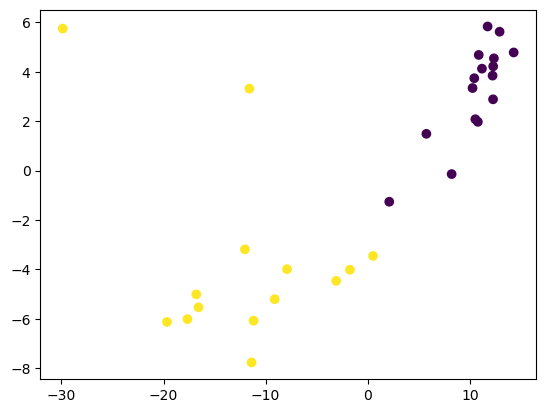

In [125]:
plt.scatter(X_ptst_transform[:,0], X_ptst_transform[:,1], c=np.ravel(Y))
plt.show()

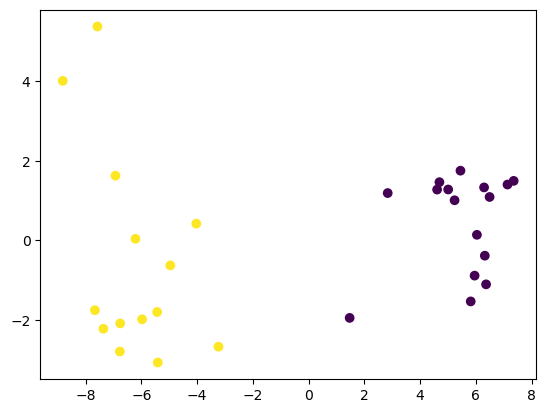

In [126]:
plt.scatter(X_rsnt_transform[:,0], X_rsnt_transform[:,1], c=np.ravel(Y))
plt.show()

In [127]:
mds_raw = MDS(random_state=0)
X_transform = mds_raw.fit_transform(X)

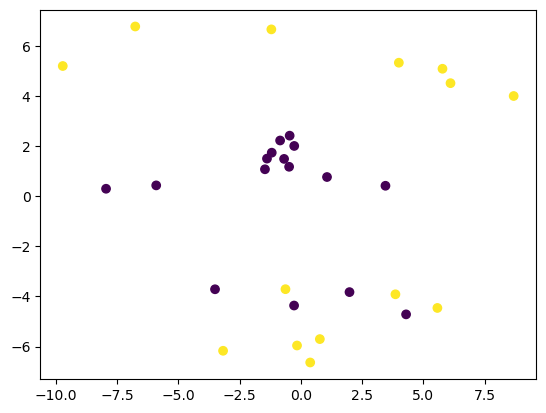

In [128]:
plt.scatter(X_transform[:,0], X_transform[:,1], c=np.ravel(Y))
plt.show()